## Modeling

In [1]:
import pandas as pd

In [2]:
springfield = pd.read_csv('data/springfield.csv', index_col='date')
springfield.index = pd.to_datetime(springfield.index)
springfield

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-04-01,80800.0,64800.0,83200.0,117900.0,38800.0,158200.0
1996-05-01,80800.0,64100.0,83200.0,116800.0,38500.0,158000.0
1996-06-01,80900.0,63500.0,83300.0,115900.0,38200.0,158000.0
1996-07-01,81100.0,63000.0,83500.0,115200.0,38000.0,158100.0
1996-08-01,81400.0,62600.0,83700.0,114800.0,37600.0,158300.0
...,...,...,...,...,...,...
2017-12-01,119900.0,94800.0,141800.0,192000.0,61000.0,257400.0
2018-01-01,120500.0,95400.0,141800.0,192900.0,61600.0,257500.0
2018-02-01,121400.0,95900.0,142800.0,195000.0,61700.0,260400.0


## Autocorrelation

In [3]:
from scripts import acf_pacf_charts

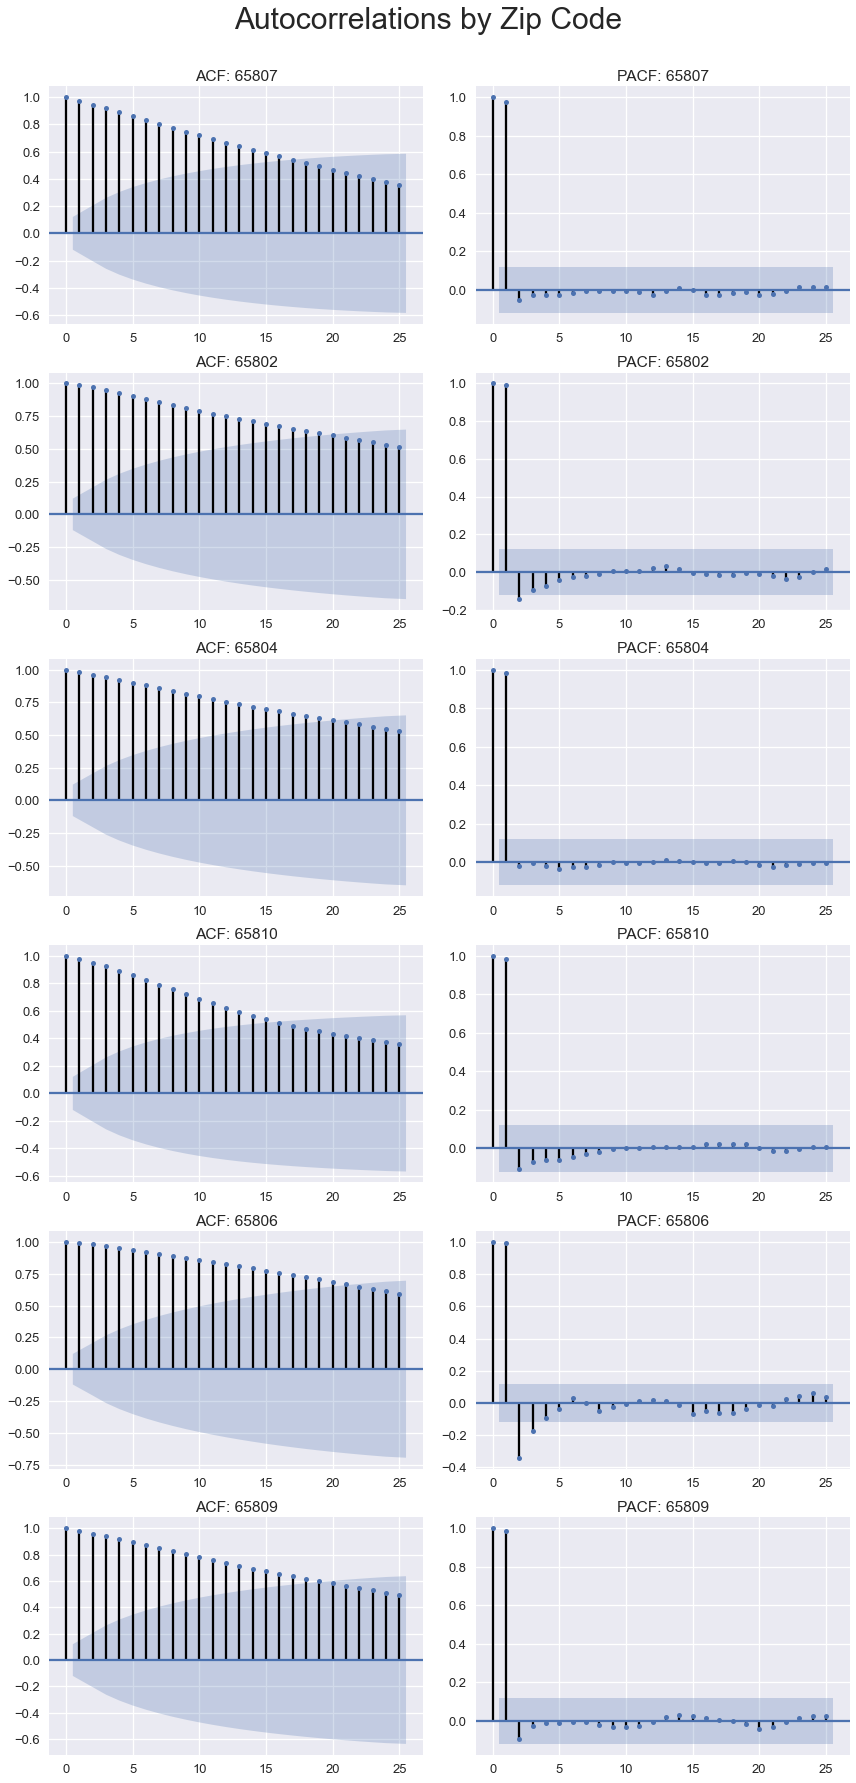

In [4]:
acf_pacf_charts(springfield, filename='autocorrelations')

The gently downwards-sloping autocorrelation plots indicate a high autocorrelation with a difference of one. The partial autocorrelation plots confirm this. We also do not see any autocorrelation with twelve, verifying our lack of seasonality we found in our EDA. We will use this data to chose our order for the baseline ARIMA model.

## Baseline ARIMA

In [5]:
from scripts import arima_analyze, arima_cross_validation
from statsmodels.tsa.arima_model import ARIMA

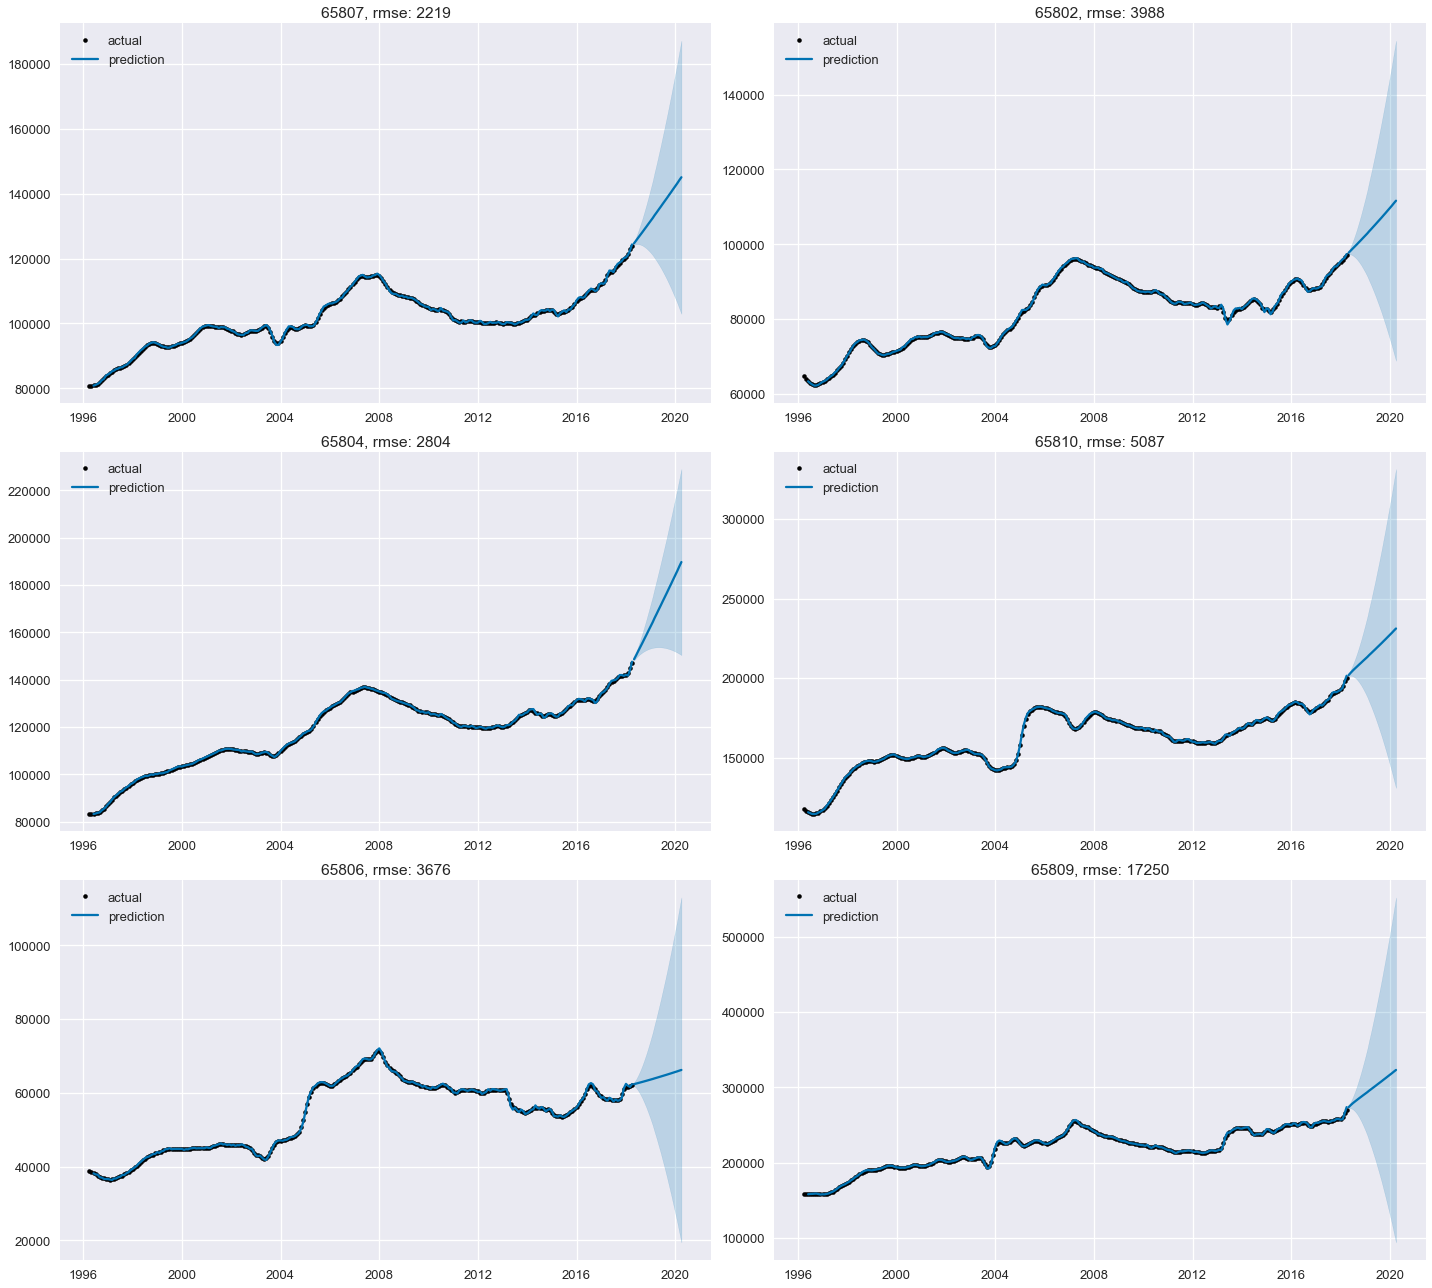

In [6]:
# order (1, 2, 0) chosen based on eda
baseline_arima_forecasts = arima_analyze(springfield, (1,2,0), filename='arima-baselines')

In [7]:
baseline_arima_forecasts.tail()

,65807,65802,65804,65810,65806,65809
2019-12-01,141392.612777,109044.679223,182326.951797,225933.271758,65486.143253,314526.958927
2020-01-01,142304.231884,109686.785429,184166.026889,227245.891203,65666.750962,316670.694730
2020-02-01,143219.194458,110333.811414,186011.643035,228567.899079,65849.052568,318823.356756
2020-03-01,144137.500499,110985.757180,187863.800234,229899.297019,66033.048069,320984.949602
2020-04-01,145059.150007,111642.622725,189722.498487,231240.085956,66218.737468,323155.475942


This is the baseline models using ARIMA and the (1, 2, 0) order as determined in our EDA. The models have cross-validated RMSE values of 2219, 3988, 2804, 5087, 3676, and 17250. Based on a cursory look at the charts, the 65804 zip code seems to have the sharpest inclune in its forecast, indicating a good investment opportunity.

## Auto-ARIMA

In [8]:
!pip install pmdarima

In [9]:
from pmdarima.arima import auto_arima

In [46]:
order_dict = {}

for col in springfield.columns:
    auto = auto_arima(springfield[col], max_order=None, max_p=10, max_q=10, d=2, max_d=5, information_criterion='aic',
                      seasonal=False)
    
    # was planning on running this wider search below overnight, but couldn't get pmdarima to import without error
    #auto = auto_arima(springfield[col], start_p=1, start_q=1, max_p=10, max_q=10, max_d=5, max_order=None, information_criterion='aic')
    
    order_dict[col] = auto.get_params()['order']
    
    print(col)
    print(auto.summary(), '\n\n\n')
    # Is it possible to just pull the AIC out of the summary?
    # I'd rather just print out one or two things as opposed to this whole summary that nobody will read.

order_dict

## print order and aic values per zip
## coef and p values

65807
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1793.163
Date:                Sun, 31 Jan 2021   AIC                           3594.327
Time:                        00:16:20   BIC                           3608.615
Sample:                             0   HQIC                          3600.069
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9804      0.052     19.010      0.000       0.879       1.081
ar.L2         -0.2335      0.027     -8.680      0.000      -0.286      -0.181
ma.L1         -0.8860      0.059    -14.996   

65809
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2170.408
Date:                Sun, 31 Jan 2021   AIC                           4344.817
Time:                        00:16:32   BIC                           4351.961
Sample:                             0   HQIC                          4347.688
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0352      0.007      5.288      0.000       0.022       0.048
sigma2      8.441e+05   3.86e+04     21.895      0.000    7.69e+05     9.2e+05
Ljung-Box (Q):                      419.15   J

{'65807': (2, 2, 1),
 '65802': (0, 2, 1),
 '65804': (1, 2, 2),
 '65810': (2, 2, 2),
 '65806': (0, 2, 1),
 '65809': (1, 2, 0)}

In [11]:
# temporary
#order_dict ={'65807': (2, 2, 1),
#             '65802': (0, 2, 1),
#             '65804': (1, 2, 2),
#             '65810': (2, 2, 2),
#             '65806': (0, 2, 1),
#             '65809': (1, 2, 0)}

By running this auto-ARIMA function, we have determined the optimal order for each of our six models. We can use this to create more accurate ARIMA models.

## Final ARIMA

In [12]:
import numpy as np

Zip Code: 65807
Starting Order: (2, 2, 1)
Final Order: (2, 2, 1)


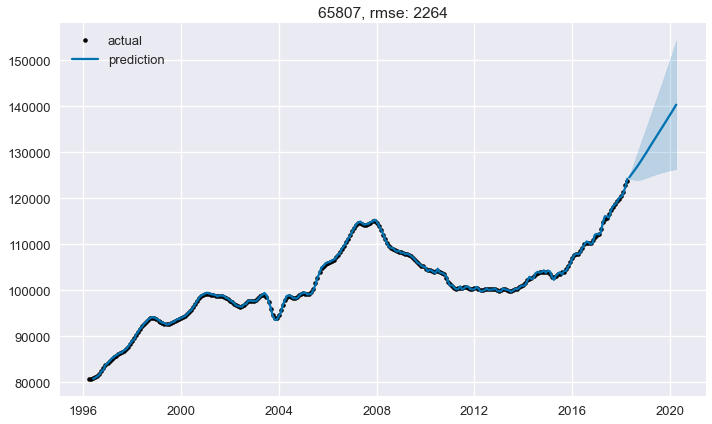

Zip Code: 65802
Starting Order: (0, 2, 1)
Final Order: (0, 2, 1)


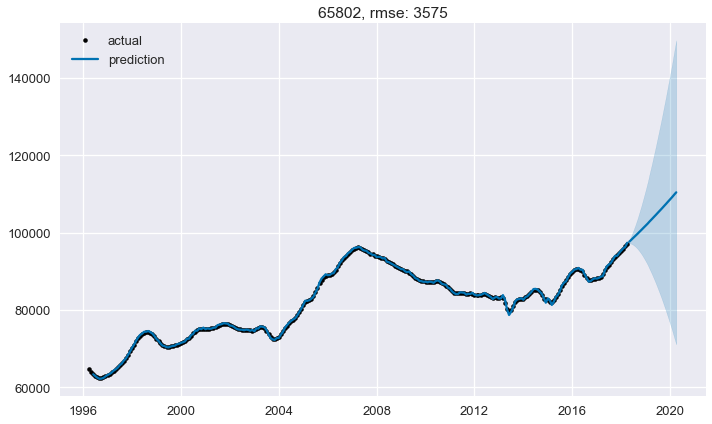

Zip Code: 65804
Starting Order: (1, 2, 2)
Final Order: (1, 2, 2)


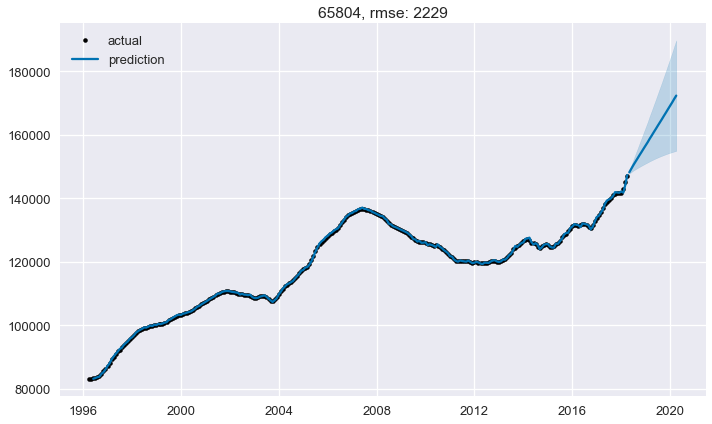

Zip Code: 65810
Starting Order: (2, 2, 2)
Final Order: (2, 2, 2)
Unable to force stationarity for cross validation model, skipping one fold
Unable to force stationarity for cross validation model, skipping one fold
Unable to force stationarity for cross validation model, skipping one fold
Unable to force stationarity for cross validation model, skipping one fold


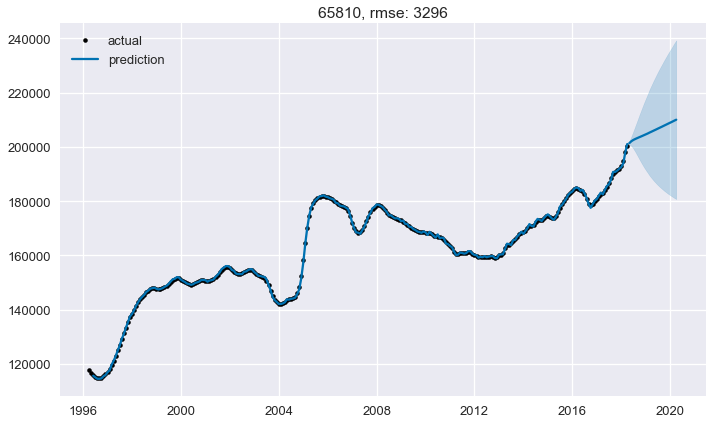

Zip Code: 65806
Starting Order: (0, 2, 1)
Final Order: (0, 2, 1)


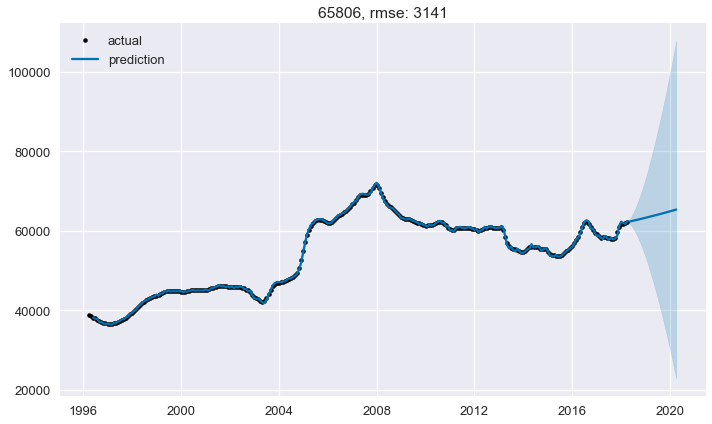

Zip Code: 65809
Starting Order: (1, 2, 0)
Final Order: (1, 2, 0)


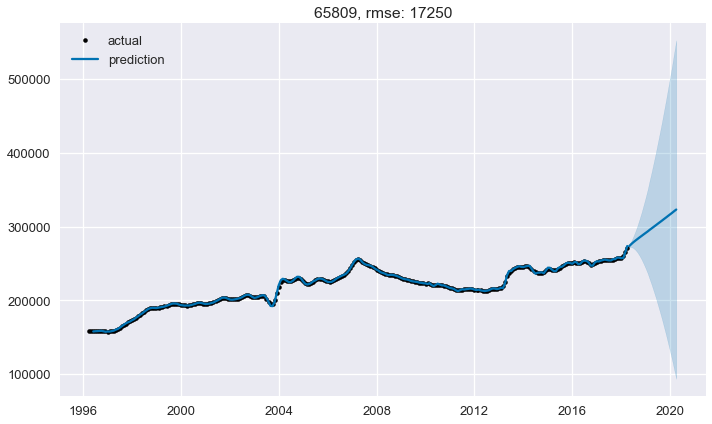

In [47]:
forecasts = {}
for col in springfield.columns:
    order = order_dict[col]
    model = ARIMA(springfield[col], order=order, freq='MS').fit()
    pvalues = model.pvalues[1:]
    
    print('Zip Code:', col)
    print('Starting Order:', order)
    
    # looping while model still has high p-values
    while np.any(pvalues>0.05):
        # loops over every p-value
        for i, p in pvalues.iteritems():
            if p > .05:
                # ar causing high p-value
                if i.startswith('ar'):
                    print('AR p-value too high, lowered order from', order)
                    order = tuple(np.subtract(order, (1,0,0)))
                # ma causing high p-value
                elif i.startswith('ma'):
                    print('MA p-value too high, lowered order from', order)
                    order = tuple(np.subtract(order, (0,0,1)))
                else:
                    print('Unable to lower order - may need to force stop to prevent infinite loop')
                    continue
                break
                
        model = ARIMA(springfield[col], order=order, freq='MS').fit()
        pvalues = model.pvalues[1:]
    
    print('Final Order:', order)
    forecasts[col] = (arima_analyze(springfield[[col]], order, filename=f'arima-final-{col}'))

Our final models all have different orders. Their rmse are 2264, 2927, 2229, 3296*, 3141, and 17250, all lower than their baselines.

The fourth model, zip code 65810, was unable to fit on the first four folds of its cross validation due to a lack of stationarity. While the whole of the data was sationary enough to fit, this may still indicate this model's forecasts to be less accurate than its relatively low rmse would otherwise suggest.

Based on the charts, zip codes 65807 and 65804 have the steepest slopes, and might be good investment opportunities.

In [ ]:
arima_forecasts = {i:k.values.flatten() for i, k in forecasts.items()}
arima_forecasts['date'] = list(forecasts.values())[0].index
forecasts_df = pd.DataFrame(arima_forecasts)
forecasts_df.set_index('date', inplace=True)
forecasts_df

In [ ]:
forecasts_df.to_csv('data/arima_predictions.csv')